In [1]:
from fastai.torch_basics import *
from fastai.basics import *
from fastai.data.all import *
from fastai.callback.all import *
from fastai.vision.all import *

from fastaudio.core.all import *
from fastaudio.augment.all import *

import torchaudio

In [2]:
p10speakers = untar_data(URLs.SPEAKERS10, extract_func = tar_extract_at_filename)

In [3]:
x = AudioGetter('', recurse = True, folders = None)
files_10 = x(p10speakers)

In [5]:
cfg_voice = AudioConfig.Voice()
a2s = AudioToSpec.from_cfg(cfg_voice)

In [6]:
auds = DataBlock(blocks = (AudioBlock.from_folder(p10speakers, crop_signal_to = 2000), CategoryBlock),
                 get_items = get_audio_files,
                 splitter = RandomSplitter(),
                 item_tfms = a2s,
                 get_y = lambda x: str(x).split('/')[-1][:5]
                )

In [7]:
cats = [y for _,y in auds.datasets(p10speakers)]

In [9]:
test_eq(min(cats).item(), 0)
test_eq(max(cats).item(), 9)

In [10]:
dbunch = auds.dataloaders(p10speakers, bs=64)

/home/karrrrrrrr/anaconda3/envs/fastaudio/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/karrrrrrrr/anaconda3/envs/fastaudio/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


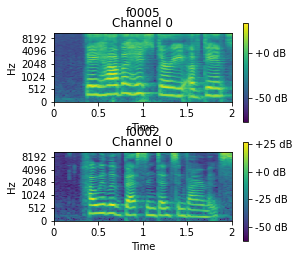

In [11]:
dbunch.show_batch(max_n = 9)

In [12]:
dbunch.one_batch()[0].shape

torch.Size([64, 1, 128, 251])

In [13]:
def alter_learner(learn, channels=1):
    learn.model[0][0].in_channels=channels
    learn.model[0][0].weight = torch.nn.parameter.Parameter(learn.model[0][0].weight[:,1,:,:].unsqueeze(1))

In [14]:
learn = Learner(dbunch,
                xresnet18(),
                torch.nn.CrossEntropyLoss(),
                metrics = [accuracy]
               )

nchannels = dbunch.one_batch()[0].shape[1]
alter_learner(learn, nchannels)

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.0030199517495930195)

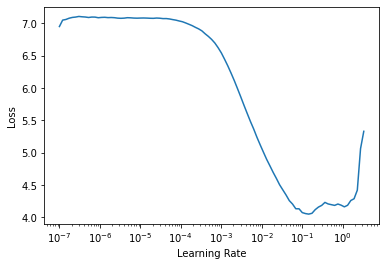

In [15]:
learn.lr_find()

In [16]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.018771,1.264866,0.549479,00:06
1,0.882932,2.193608,0.455729,00:06
2,0.445762,3.457268,0.542969,00:06
3,0.245040,0.932124,0.811198,00:06
4,0.138128,11.654041,0.187500,00:06
5,0.097645,0.167150,0.944010,00:06
6,0.059085,0.085614,0.975260,00:06
7,0.036115,0.053566,0.985677,00:06
8,0.020787,0.039791,0.989583,00:06
9,0.012186,0.039262,0.988281,00:06
